Mask out-of-source-domain / unmapped grid cells of the target grid
================

## for the nearest-neighbour method ('nearest_s2d') of xESMF
### Example of a regional curvilinear grid

### Basic Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import sparse as sps
print("Using xESMF in version %s" % xe.__version__)

from pathlib import Path
from git import Repo
import os

import warnings
warnings.simplefilter("ignore") 
#with warnings.catch_warnings():
#        warnings.simplefilter("ignore")

xr.set_options(display_style='html');

Using xESMF in version 0.6.1.post0


##### Initialize test data

In [6]:
# Initialize mini-esgf-data
MINIESGF_URL="https://github.com/roocs/mini-esgf-data"
branch = "master"
MINIESGF = Path(Path.home(),".mini-esgf-data", branch)

# Retrieve mini-esgf test data
if not os.path.isdir(MINIESGF):
    repo = Repo.clone_from(MINIESGF_URL, MINIESGF)
    repo.git.checkout(branch)
else:
    repo = Repo(MINIESGF)
    repo.git.checkout(branch)
    repo.remotes[0].pull()
    
MINIESGF=Path(MINIESGF,"test_data")

### Load the dataset

In [7]:
# Load the dataset
ds_path = Path(MINIESGF, "pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/MPI-M-MPI-ESM-LR/"
                         "rcp85/r1i1p1/GERICS-REMO2015/v1/mon/tas/v20191029/"
                         "tas_EUR-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_mon_202101.nc")
ds_in = xr.open_dataset(ds_path)
ds_in

<xarray.Dataset>
Dimensions:                     (rlat: 201, rlon: 225, vertices: 4, time: 1, bnds: 2)
Coordinates:
    height                      float64 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
  * time                        (time) datetime64[ns] 2021-01-16T12:00:00
Dimensions without coordinates: vertices, bnds
Data variables:
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    rotated_latitude_longitude  int32 ...
    tas                         (time, rlat, rlon) float32 ...
    time_bnds                   (time, bnds) datetime64[ns] ...
Attributes: (12/35)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  rcp85
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/77bb3489-7951-4f31-bf63-3022...
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...

### Plot the grid

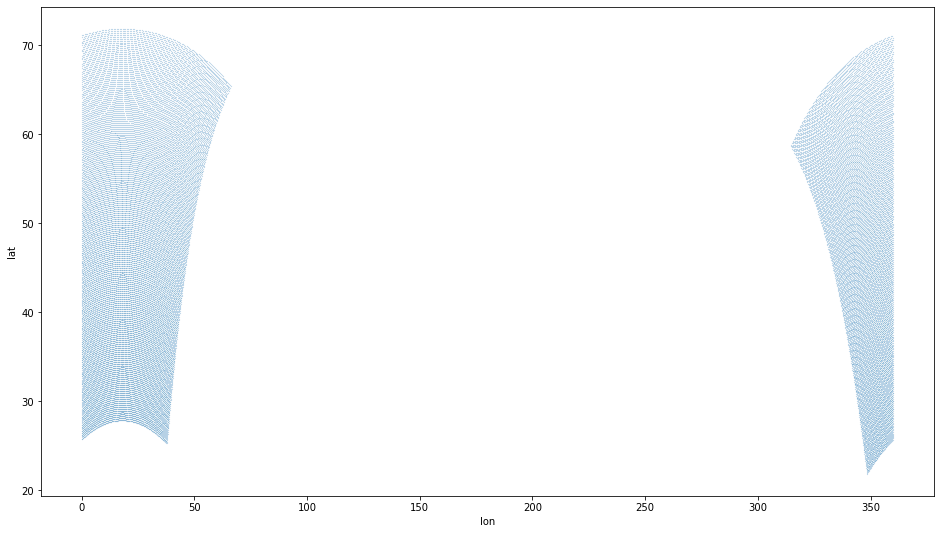

In [8]:
# plot grid
plt.figure(figsize=(16,9))
plt.scatter(ds_in['lon'], ds_in['lat'], s=0.01)  
plt.xlabel('lon');
plt.ylabel('lat');

### Plot the data

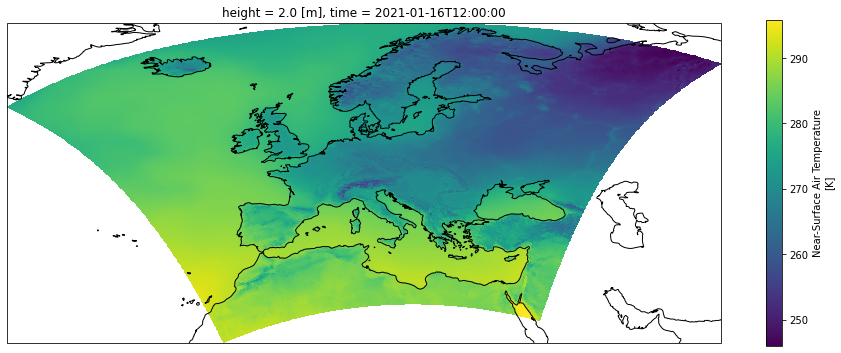

In [9]:
# Using matplotlib / cartopy / xarray
plt.figure(figsize=(16,6));
ax = plt.axes(projection=ccrs.PlateCarree());
ds_in.tas.isel(time=0).plot.pcolormesh(ax=ax, x='lon', y='lat', shading='flat');
ax.coastlines();

### Set up the destination grid

In [10]:
# Specify a global 1 deg grid
ds_out = xe.util.grid_global(1,1) # global 5 degree grid
ds_out

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

### Calculate the distances

In [11]:
from scipy.spatial import cKDTree

def lon_lat_to_cartesian(lon, lat, R = 6371000):
    """
    # Taken from FESOM/pyfesom - https://github.com/FESOM/pyfesom/blob/master/pyfesom/regriding.py
    
    Calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    Parameters
    ----------
    lon : 1d array
        longitudes
    lat : 1d array
        latitudes
    R   : float
        radius of the sphere
    Returns
    -------
    x,y,z : 1d arrays
        cartesian coordinates
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r) * np.cos(lon_r)
    y =  R * np.cos(lat_r) * np.sin(lon_r)
    z =  R * np.sin(lat_r)
    return x,y,z

def create_indexes_and_distances(lon_in, lat_in, lon_out, lat_out, n_jobs=2,):
    '''
    # Adapted from FESOM/pyfesom - https://github.com/FESOM/pyfesom/blob/master/pyfesom/regriding.py
    
    Creates KDTree object and queries it for indexes of points in source grid that are closest to the
    points of the target grid. Also returns distances between the selected original points and target points
    as well as the average spacing of the source grid points.
 
    Parameters
    ----------
    lon_in/lat_in : array
        2d arrays with source grid values.
    lon_out/lat_out : array
        2d arrays with target grid values.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors. 
    inds : ndarray of ints
        The locations of the neighbors in data.  
    approx_res: float
        Approximate grid_spacing
    '''
   
    # Required for 1D coordinate variables in a lat-lon grid
    # Not required for an unstructured grid with 1D coordinate variables
    if len(lon_in.shape)==1:
        lon_in, lat_in = np.meshgrid(lon_in, lat_in)
    if len(lon_out.shape)==1:
        lon_out, lat_out = np.meshgrid(lon_out, lat_out)
    
    xs, ys, zs = lon_lat_to_cartesian(lon_in.flatten(), lat_in.flatten())
    xt, yt, zt = lon_lat_to_cartesian(lon_out.flatten(), lat_out.flatten()) 
    
    # Calculate shortest distances between destination and source grid points
    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k = 1, n_jobs=n_jobs)
    
    # Calculate average spacing of source grid points
    approx_res = np.average(tree.query(list(zip(xs, ys, zs)), k = 2, n_jobs=n_jobs)[0][:, 1])

    return distances, inds, approx_res

In [12]:
# Calculate the distances to the nearest source cells
dist,ind,res = create_indexes_and_distances(ds_in.lon.values,
                                            ds_in.lat.values,
                                            ds_out.lon.values,
                                            ds_out.lat.values)

### Create output mask to mask out-of-source-domain / unmapped grid cells of the target grid

In [13]:
# Create the mask
mask=np.where(dist>=res*2, False, True).reshape(180,360)

# Copy the output grid as reference
ds_out_unmasked = ds_out.copy()

# Specify the created mask as output mask 
ds_out['mask']=xr.DataArray(data=mask, dims=["lat", "lon"])

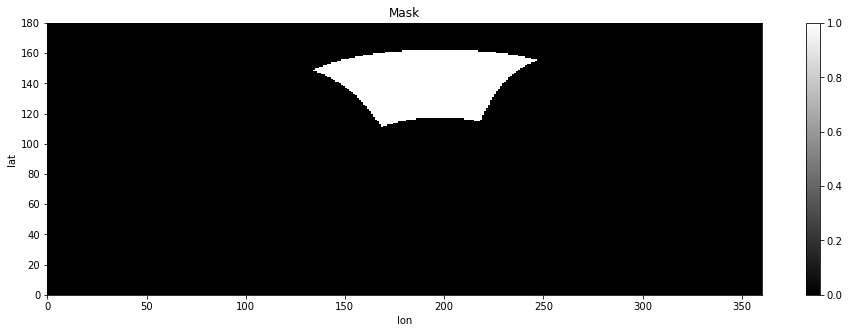

In [14]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(16,5))
im=axes.pcolormesh(mask, cmap="binary_r")
fig.colorbar(im, ax=axes)
axes.set_xlabel('lon');
axes.set_ylabel('lat');
axes.set_title('Mask');

### Calculate the regridding weights in three fashions:

1. Create weights with applied target grid mask
2. Create weights without applied target grid mask
3. Case 2, but manipulating the weights afterwards to set contribution of Case 1 masked cells to 0

In [15]:
# Create regridding weights incl. and excl. the specified output mask
#  - add_nans_to_weights is applied by default
def regrid(ds_in, ds_out, method):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method)

# Just looking at nearest_s2d
# method_list = ['bilinear','nearest_s2d', 'conservative', 'conservative_normed', 'patch']
method_list = ['nearest_s2d']

regridder={}
for method in method_list:
    # Excl. output mask - as reference
    print()
    %time regridder[method+"_unmasked"]=regrid(ds_in, ds_out_unmasked, method)
    print(regridder[method+"_unmasked"])
    
    # Incl. output mask - much less time consuming
    print()
    %time regridder[method]=regrid(ds_in, ds_out, method)
    print(regridder[method])
    
    # Excl. output mask - to be thereafter manipulated
    print()
    %time regridder[method+"_nans"]=regrid(ds_in, ds_out_unmasked, method)
    print(regridder[method+"_nans"])


CPU times: user 48.7 s, sys: 41.2 ms, total: 48.7 s
Wall time: 48.9 s
xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_201x225_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (201, 225) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

CPU times: user 390 ms, sys: 8.02 ms, total: 398 ms
Wall time: 397 ms
xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_201x225_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (201, 225) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

CPU times: user 42.9 s, sys: 8.59 ms, total: 42.9 s
Wall time: 43.1 s
xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_201x225_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (201, 225) 
Output grid shape:          (180, 360) 
Periodic in longitud

In [16]:
# Function to set the contribution of certain source grid cells to 0
def add_nans_to_weights_and_mask(weights, mask_out):
    """Add NaN in empty rows of the regridding weights sparse matrix.

    By default, empty rows in the weights sparse matrix are interpreted as zeroes. This can become problematic
    when the field being interpreted has legitimate null values. This function inserts NaN values in each row to
    make sure empty weights are propagated as NaNs instead of zeros.

    Parameters
    ----------
    weights : DataArray backed by a sparse.COO array
      Sparse weights matrix.
    mask_out: numpy.array of type bool or int
       with shape of the (flattened) output grid.

    Returns
    -------
    DataArray backed by a sparse.COO array
      Sparse weights matrix.
    """

    # Taken from @trondkr and adapted by @raphaeldussin to use `lil`.
    # lil matrix is better than CSR when changing sparsity
    M = weights.data.to_scipy_sparse().tolil()    
    
    # Create "unmapped" cells out of all masked target grid cells
    # This should probably not be used with conservative_normed (and nearest_d2s?) method.
    # I tested it yet only for nearest_s2d.    
    tozero=np.where(mask_out.ravel()==0)[0]
    for krow in tozero:
        M.rows[krow]=[0]
        M.data[krow]=[np.NaN]
    
    # replace empty rows by one NaN value at element 0 (arbitrary)
    # so that remapped element become NaN instead of zero
    for krow in range(len(M.rows)):
        M.rows[krow] = [0] if M.rows[krow] == [] else M.rows[krow]
        M.data[krow] = [np.NaN] if M.data[krow] == [] else M.data[krow]
    # update regridder weights (in COO)
    weights = weights.copy(data=sps.COO.from_scipy_sparse(M))
    return weights

In [17]:
# Weights manipulation
# Add 0s to the weight file where values should be masked, then apply xesmf.smm.add_nans_to_weights
# (both done via above function)
# ICON-ESM OES
regridder["nearest_s2d_nans"].weights = add_nans_to_weights_and_mask(
    regridder["nearest_s2d_nans"].weights,
    ds_out["mask"].data
)

### Perform the regridding

In [18]:
# Perform regridding
for method in method_list:
    # unmasked case
    ds_out["tas_"+method+"_unmasked"]=regridder[method+"_unmasked"](ds_in.tas)
    # masked case
    ds_out["tas_"+method]=regridder[method](ds_in.tas)
    # manipulated weights case
    ds_out["tas_"+method+"_nans"]=regridder[method+"_nans"](ds_in.tas)

### Plot regridded data

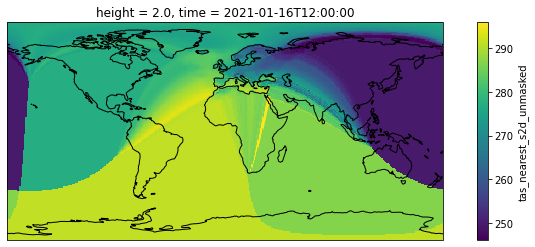

In [19]:
# unmasked case
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tas_nearest_s2d_unmasked"].isel(time=0).plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

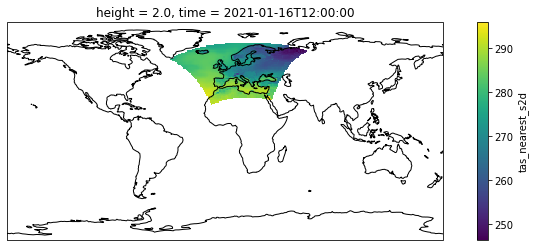

In [20]:
# masked case
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tas_nearest_s2d"].isel(time=0).plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

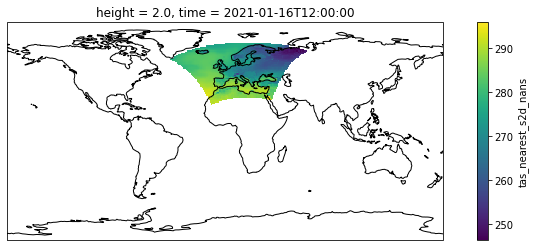

In [21]:
# manipulated weights case
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tas_nearest_s2d_nans"].isel(time=0).plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();